# Biblioteca

In [12]:
!pip install --upgrade matplotlib

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# A/B Testing

## Simulate beta posterior:

In [3]:
def simulate_beta_posterior(trials,beta_prior_a,beta_prior_b):

    num_sucesses = np.sum(trials) # Count the number of successes in the trials
    posterior_draws = np.random.beta(
                                        num_sucesses + beta_prior_a, 
                                        len(trials) - num_sucesses + beta_prior_b, 
                                        100000
                                    )

    return posterior_draws

## How beta prior looks like

In [4]:
prior_click = simulate_beta_posterior([],1,1)

<Axes: ylabel='Density'>

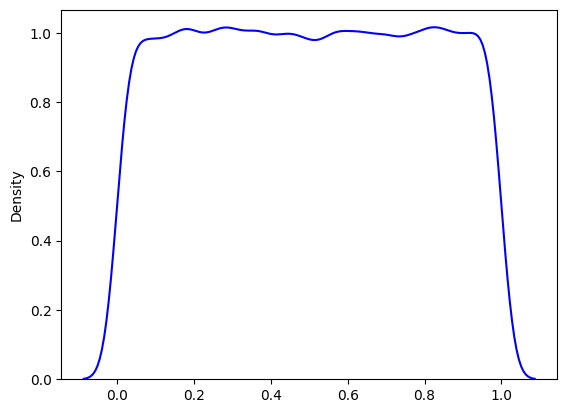

In [5]:
sns.kdeplot(prior_click, label='Prior', color='blue')

## Simulate testing data

In [6]:
A_clicks = np.array([1, 0, 1, 0, 1, 1, 0, 0, 1, 0])
B_clicks = np.array([ 0, 0, 0, 0, 0, 0, 1, 1, 0, 1])

In [7]:
# beta = 1,1 prior ???

A_posterior = simulate_beta_posterior(A_clicks, 1, 1)
B_posterior = simulate_beta_posterior(B_clicks, 1, 1)

## Comparing posterior distributions

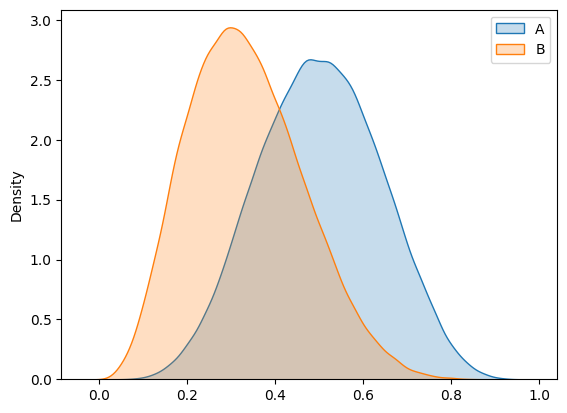

In [8]:
sns.kdeplot(A_posterior, label='A', fill=True)
sns.kdeplot(B_posterior, label='B',fill = True)
plt.legend()
plt.show()

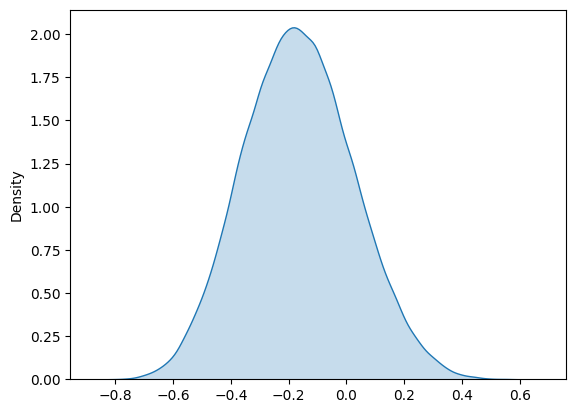

In [9]:
diff = B_posterior - A_posterior

sns.kdeplot(diff, label='B - A', fill=True)
plt.show()

### Measuring the difference

In [10]:
(diff>0).mean() 

np.float64(0.19299)

There's 19% chance that B is better than A.

### If we wrong deploy the worst version?

In [11]:
loss = diff[diff<0]

expected_loss = loss.mean()
print(f"Expected loss: {expected_loss:.3f}")

Expected loss: -0.233


Cool! Now you see what simulate_beta_posterior() is doing: based on the binomial data and the prior, it samples posterior draws. Notice how using the Beta(1, 10) prior shifts the posterior to the left compared to Beta(1, 1). This effect is quite strong, as there is little data: just 10 coin flips. Let's move on to A/B testing!

# Example 2 

After a successful career episode at the Department for Health, you switch to marketing. Your new company has just run two pilot advertising campaigns: one for sneakers, and one for clothes. Your job is to find out which one was more effective as measured by the click-through rate and should be rolled out to a larger audience.

You decide to run A/B testing, modeling the data using the binomial likelihood. You found out that a typical click-through rate for the previous ads has been around 15% recently, with results varying between 5% and 30%. Based on this, you conclude that 
 would be a good prior for the click-through rate.

C:\Users\rodri\AppData\Local\Temp\ipykernel_58876\869098009.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prior_draws , shade=True, label="prior")


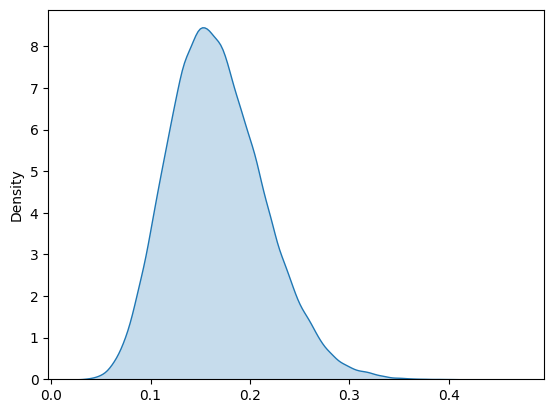

In [12]:
# Generate prior draws
# How we conclude that the prior is beta(10,50) is not clear from the code.
prior_draws = np.random.beta(10, 50, 100000)

# Plot the prior
sns.kdeplot(prior_draws , shade=True, label="prior")
plt.show()

In [13]:
ads = pd.read_csv("data/ads.csv")

In [14]:
# Extract the banner_clicked column for each product
clothes_clicked = ads.loc[ads['product'] =='clothes']['banner_clicked']
sneakers_clicked = ads.loc[ads['product'] =='sneakers']['banner_clicked']

In [15]:
# Simulate posterior draws for each product
clothes_posterior = simulate_beta_posterior(clothes_clicked, 10, 50)
sneakers_posterior = simulate_beta_posterior(sneakers_clicked, 10, 50)

C:\Users\rodri\AppData\Local\Temp\ipykernel_58876\3738189294.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(clothes_posterior, shade=True, label="clothes")
C:\Users\rodri\AppData\Local\Temp\ipykernel_58876\3738189294.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sneakers_posterior, shade=True, label="sneakers")


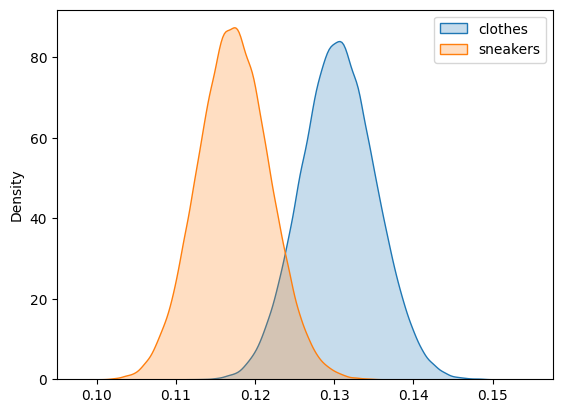

In [16]:
sns.kdeplot(clothes_posterior, shade=True, label="clothes")
sns.kdeplot(sneakers_posterior, shade=True, label="sneakers")
plt.legend()
plt.show()

Correct, that's false! We cannot be sure about it, since the two posteriors overlap, so it is actually possible for the sneakers campaign to be bettter. But how likely is it? Let's find out in the next exercise!

You have just discovered that clothes ads are likely to have a higher click ratio than sneakers ads. But what is the exact probability that this is the case? To find out, you will have to calculate the posterior difference between clothes and sneakers click rates. Then, you will calculate a credible interval for the difference to measure the uncertainty in the estimate. Finally, you will calculate the percentage of cases where this difference is positive, which corresponds to clothes click rate being higher. Let's get on with it!

C:\Users\rodri\AppData\Local\Temp\ipykernel_58876\723752353.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diff, shade=True, label="diff")


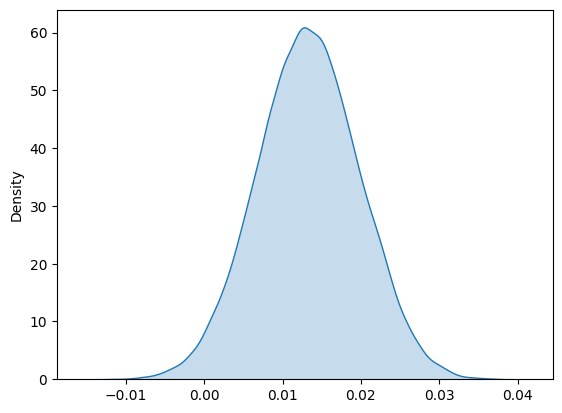

In [17]:
# Calculate posterior difference and plot it
diff = clothes_posterior - sneakers_posterior
sns.kdeplot(diff, shade=True, label="diff")
plt.show()

In [18]:
#!pip install arviz

In [19]:
import arviz as az

In [23]:
# Calculate the 90% HPD credible interval of the posterior difference, assign it to interval, and print it.
az.hdi(diff, hdi_prob=0.90) # até 2.4% melhor 

array([0.0026259 , 0.02421656])

In [22]:
# Calculate and print probability of clothes ad being better
clothes_better_prob = (diff>0).mean()
print(clothes_better_prob)

0.9783


Well done! Take a look at the posterior density plot of the difference in click rates: it is very likely positive, indicating that clothes are likely better. The credible interaval indicates that with 90% probability, the clothes ads click rate is up to 2.4 percentage points higher than the one for sneakers. Finally, the probability that the clothes click rate is higher is 98%. Great! But there is a 2% chance that actually sneakers ads are better! How great is that risk? Let's find out!

The answer to this is the expected loss: the average posterior difference between the two click-through ratios given that sneakers ads do better. To calculate it, you only need to take the entries in the posterior difference where the sneakers click-through rate is higher and compute their average.

In [24]:
# Slice diff to take only cases where it is negative
loss = diff[diff<0]

# Compute and print expected loss
expected_loss = np.mean(loss)
print(expected_loss)

-0.0024958411349950346


Terrific job! You can sefely roll out the clothes campaign to a larger audience. You are 98% sure it has a higher click rare, and even if the 2% risk of this being a wrong decision materializes, you will only lose 0.2 percentage points in the click rate, which is a very small risk!